## Results notebook
---

Walking through the steps necessary to generate the results for the AKI Flagger paper. The main results are as follows: 

- the Venn (Euler) diagrams showing overlap between captured patient groups
- the number of patients in each group who go on to have worsening kidney function (proxied by progression in AKI stage), receive dialysis, or die. 
- 

In [1]:
!pip install akiFlagger


(base) c:\Users\ishan\Desktop\ishan\Projects\StandardizingAKI\notebooks>DOSKEY ls=dir 

(base) c:\Users\ishan\Desktop\ishan\Projects\StandardizingAKI\notebooks>cls


In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys

import seaborn as sns
from akiFlagger import AKIFlagger
from matplotlib_venn import venn3

from sklearn.metrics import confusion_matrix, roc_auc_score

### User-defined functions

***
*plotAKIoverlap()* generates Euler plots (Venn diagrams) for the overlap between captured patient groups for each of the definitions

    Args:
        dataFRAME (pd.Dataframe) the dataframe with each of the AKI definitions
        stage (int) the stage of AKI to select by
        
*printDescriptiveStatistics()* prints the sensitivity, specificity, precision, F1 score, positive and negative predictive values (PPV/NPV) for a given (yTRUE, yPRED) pair combin

    Args: 
        dataFRAME (pd.Dataframe) the datamframe with each of the AKI definitions
        yTRUE (string) ground truth / outcome variable; expected to be a column in dataFRAME 
        yPRED (string) prediction / AKI definition; expected to be a column in the dataFRAME

In [3]:
def plotAKIoverlap(dataFRAME, stage = 1, returnCapturedPatients = False, plot = True):
    ''' Plotting function to illustrate the differences between which patient populations are captured by each definition
    '''
    captured_patients = dict()
    captured_patientsLIST = [set(dataFRAME[dataFRAME[col] > stage - 1].index.get_level_values(level='patient_id').unique()) for col in dataFRAME]
    captured_patients[flaggerDefinitions[0]], captured_patients[flaggerDefinitions[1]], captured_patients[flaggerDefinitions[2]] = captured_patientsLIST 

    if returnCapturedPatients & plot:
        return captured_patients, venn3(
            subsets = [captured_patients[flaggerDefinitions[0]], 
            captured_patients[flaggerDefinitions[1]], 
            captured_patients[flaggerDefinitions[2]]], set_labels = tuple(df for df in flaggerDefinitions)
        )

    if returnCapturedPatients:
        return captured_patients
    
    if plot:
        return venn3(
            subsets = [captured_patients[flaggerDefinitions[0]], 
            captured_patients[flaggerDefinitions[1]], 
            captured_patients[flaggerDefinitions[2]]], set_labels = tuple(df for df in flaggerDefinitions)
        )

def printDescriptiveStatistics(dataFRAME = None, level = "creatinine",
                               yTRUE = None, yPRED = None):
    ''' 
    For a given definition & percent increase, find the confusion matrix (& print corresponding descriptive statistics)
    Each of these. 
    '''

    #yTRUE = dataFRAME.outcome
    #yPRED = dataFRAME[AKIdefinitions[AKIdefinitions.index(definitionOfInterest)]]
    yTRUE = dataFRAME[yTRUE]
    yPRED = dataFRAME[yPRED]
    
    TN, FP, FN, TP = confusion_matrix(yTRUE, yPRED).ravel()
    AUC = roc_auc_score(yTRUE, yPRED)

    SENS = TP / (TP + FN)
    SPEC = TN / (TN + FP)
    PREC = TP / (TP + FP)
    F1Sc = 2*TP / (2*TP + (FP+FN))

    PPV = TP / (TP + FP)
    NPV = TN / (TN + FN)

    STATS = np.array([SENS, SPEC, PREC, F1Sc, PPV, NPV, AUC])

    print('''
    SENS: {}
    SPEC: {}
    PREC: {}
    F1 score: {}

    PPV: {}
    NPV: {}

    AUC: {}

    '''.format(*np.round(STATS, decimals = 3)))
    print("TN: {}, FP: {}. FN: {}, TP: {}".format(TN, FP, FN, TP), " <- CM raveled")

    return(confusion_matrix(yTRUE, yPRED))

def plotCreatinineTrajectory(MRN, rows = None):
    plotSubset = flaggerOutput.loc[flaggerOutput.index.get_level_values(level='patient_id') == MRN]
    plotSubset = plotSubset.merge(df.set_index(index).creatinine, on = index) # Add in the creatinine values from df
    plotSubset = plotSubset[rows]

    fig, ax = plt.subplots(nrows=1, ncols=1)
    plt.plot(plotSubset.index.get_level_values(level='time'), plotSubset.creatinine)
    plt.xlabel('Time')
    plt.ylabel('Creatinine')

### Parameters
---

#### _General parameters_

*STAGE* is the staging of AKI; 1 2 or 3. 

*index* is a Python multi-index (id est hierarchical index) 

*flaggerDefinitions* 

#### _Flagger parameters_

The definitions are specified as boolean parameters within the internal function (the main `AKIFlagger` class and the `returnAKIpatients()` function). The dictionary is essentially a mapping between the flagger definitions are string inputs to the boolean inputs; a more human-readable input into a 3D bool vector. 

`padding` defaults to 4 hours; I am *explicitly* mentioning this here to make it clear (the first small divergence from the KDIGO definitions.

In [5]:
# Parameters
STAGE = 1 
index = ["patient_id", "time"]
flaggerDefinitions = ["RMW", "HBT", "BCI"]
dataFolder = r"H:\AKIFlagger\output"
dataPath = os.path.join(dataFolder, "flaggerInput.csv")
outcomesPath = os.path.join(dataFolder, "flaggerOutcomes.csv") #H:\AKIFlagger\output\flagger creatinine data 04-20-2022.csv
outcomeCols = ["death_time", "dialysis_time", "progression_time"]
selectCols = ["patient_id", "time", "inpatient", "creatinine", "age", "sex", "admission", # Flagger input columns
              "admit_creatinine"] + outcomeCols # Outcome columns
vennOutPath = "vennDiagrams" # Save directories
colors = {
    '###': 'green', # Replace ### with 
    '###': 'green', # 
    '###': 'red',   # (examplePatientsRMW)
    '###': 'green', # 
    '###': 'green'  # 5 mrns in total
}

# Flagger-specific parameters
fParams = dict() # A mapping between definition strings and booleans
fParams[flaggerDefinitions[0]] = {"RM_window": True, "HB_trumping": False, "eGFR_impute": False}
fParams[flaggerDefinitions[1]] = {"RM_window": False, "HB_trumping": True, "eGFR_impute": False}
fParams[flaggerDefinitions[2]] = {"RM_window": False, "HB_trumping": True, "eGFR_impute": True}
padding = '4hours'

### Read in the data; take a peak at what the input looks like

In [31]:
# Read in data
pDF1 = pd.read_csv(dataPath)
pDF1['time'] = pd.to_datetime(pDF1.time)
pDF1 = pDF1.rename(columns= {"pat_mrn_id": "patient_id",
                             "hosp_admsn_time": "admission"})

pDF1 = pDF1.loc[:, selectCols]
flaggerInput = pDF1
outcomes = pDF1.loc[:, outcomeCols]
print(pDF1.shape)
#pDF1.head()

(499942, 11)


### Run the AKIFlagger 

In [ ]:
# Run the flagger
_flaggerOutput = [AKIFlagger(**fParams[flaggerDefinitions[0]]).returnAKIpatients(flaggerInput).aki,
                    AKIFlagger(**fParams[flaggerDefinitions[1]]).returnAKIpatients(flaggerInput).aki,
                    AKIFlagger(**fParams[flaggerDefinitions[2]]).returnAKIpatients(flaggerInput).aki]
flaggerOutput = pd.concat([i for i in _flaggerOutput], axis = 1)
flaggerOutput.columns = ["RMW", "HBT", "BCI"]
print(flaggerOutput.shape)
print(flaggerInput.shape)
flaggerOutput.head()

c:\Users\ishan\anaconda3\lib\site-packages\matplotlib_venn\_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


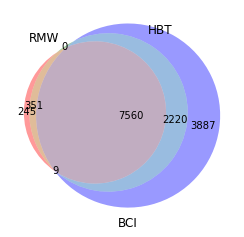

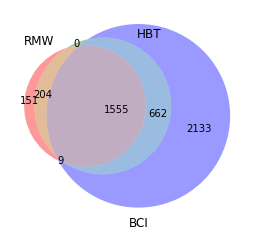

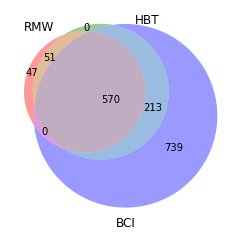

In [8]:
STAGE = 1
plt.figure()
plotAKIoverlap(flaggerOutput, stage = STAGE)
#plt.savefig(os.path.join(dataFolder, vennOutPath, "01stage{}overlap.png".format(STAGE)))

STAGE = 2
plt.figure()
plotAKIoverlap(flaggerOutput, stage = STAGE)
#plt.savefig(os.path.join(dataFolder, vennOutPath, "01stage{}overlap.png".format(STAGE)))


STAGE = 3
plt.figure()
plotAKIoverlap(flaggerOutput, stage = STAGE)
#plt.savefig(os.path.join(dataFolder, vennOutPath, "01stage{}overlap.png".format(STAGE)))

In [9]:
STAGE = 1
df = flaggerInput.merge(flaggerOutput > STAGE - 1, on = ["patient_id", "time"]) # Handles the boolean conversion
df['outcome'] = df['creatinine'] >= df['admit_creatinine']*2

# First, by creatinine
print("-------------------")
print("CONFUSION MATRICES: \n(creatinine-level)")
print("-------------------")
printDescriptiveStatistics(dataFRAME = df, level = 'creatinine',
                           yTRUE = 'outcome', yPRED = 'RMW')
print("----------------------------------------")
printDescriptiveStatistics(dataFRAME = df, level = 'creatinine',
                           yTRUE = 'outcome', yPRED = 'HBT')
print("----------------------------------------")
printDescriptiveStatistics(dataFRAME = df, level = 'creatinine',
                           yTRUE = 'outcome', yPRED = 'BCI')
print("----------------------------------------")

-------------------
CONFUSION MATRICES: 
(creatinine-level)
-------------------

    SENS: 0.713
    SPEC: 0.941
    PREC: 0.233
    F1 score: 0.351

    PPV: 0.233
    NPV: 0.992

    AUC: 0.827

    
TN: 458791, FP: 28874. FN: 3521, TP: 8756  <- CM raveled
----------------------------------------

    SENS: 0.74
    SPEC: 0.916
    PREC: 0.182
    F1 score: 0.293

    PPV: 0.182
    NPV: 0.993

    AUC: 0.828

    
TN: 446888, FP: 40777. FN: 3188, TP: 9089  <- CM raveled
----------------------------------------

    SENS: 0.781
    SPEC: 0.861
    PREC: 0.124
    F1 score: 0.214

    PPV: 0.124
    NPV: 0.994

    AUC: 0.821

    
TN: 419758, FP: 67907. FN: 2689, TP: 9588  <- CM raveled
----------------------------------------


In [10]:
# Then, by patient

#combined_filterANY = flaggerOutput.groupby('patient_id').filter(lambda s: np.any(s))
# If extra time, see what combined_filterANY is returning
yPREDs = flaggerOutput.groupby('patient_id').any() # This is what I'm looking for : are there ANY 
df_ptlvl = yPREDs.merge(df.groupby('patient_id').outcome.any(), on = "patient_id")

# ez
print("-------------------")
print("CONFUSION MATRICES: \n(patient-level)")
print("-------------------")
printDescriptiveStatistics(dataFRAME = df_ptlvl, level = 'creatinine',
                           yTRUE = 'outcome', yPRED = 'RMW')
print("----------------------------------------")
printDescriptiveStatistics(dataFRAME = df_ptlvl, level = 'creatinine',
                           yTRUE = 'outcome', yPRED = 'HBT')
print("----------------------------------------")
printDescriptiveStatistics(dataFRAME = df_ptlvl, level = 'creatinine',
                           yTRUE = 'outcome', yPRED = 'BCI')
print("----------------------------------------")

-------------------
CONFUSION MATRICES: 
(patient-level)
-------------------

    SENS: 0.859
    SPEC: 0.824
    PREC: 0.17
    F1 score: 0.283

    PPV: 0.17
    NPV: 0.993

    AUC: 0.842

    
TN: 31714, FP: 6780. FN: 227, TP: 1385  <- CM raveled
----------------------------------------

    SENS: 0.883
    SPEC: 0.774
    PREC: 0.14
    F1 score: 0.242

    PPV: 0.14
    NPV: 0.994

    AUC: 0.828

    
TN: 29786, FP: 8708. FN: 189, TP: 1423  <- CM raveled
----------------------------------------

    SENS: 0.927
    SPEC: 0.684
    PREC: 0.109
    F1 score: 0.196

    PPV: 0.109
    NPV: 0.996

    AUC: 0.805

    
TN: 26313, FP: 12181. FN: 117, TP: 1495  <- CM raveled
----------------------------------------


### Example patients flagged as AKI

#### Basic measurement characteristics of patient data
---
`flaggerOutput.groupby('patient_id').count().RMW`  shows the number 

In [11]:
captured_patients = plotAKIoverlap(flaggerOutput, stage = 1, returnCapturedPatients=True, plot = False)
examplePatientsRMW = list(captured_patients['RMW'])[:1]
examplePatientsRMW

['MR2110315']

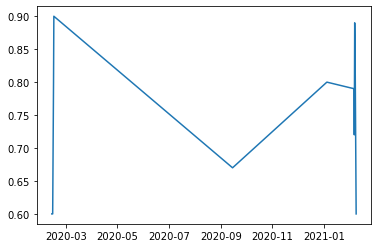

In [13]:
plotSubset = flaggerOutput.loc[flaggerOutput.index.get_level_values(level='patient_id').isin(examplePatientsRMW)]
plotSubset = plotSubset.merge(df.set_index(index).creatinine, on = index) # Add in the creatinine values from df
# plotSubset = plotSubset.reset_index()
# plotSubset['color'] = plotSubset.patient_id.map(colors)
# plotSubset_ = plotSubset.pivot(index = 'time', columns = 'color', values = 'creatinine')
# plotSubset_.plot(color = plotSubset_.columns)

# Plotting
fig, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(plotSubset.index.get_level_values(level='time'), plotSubset.creatinine)

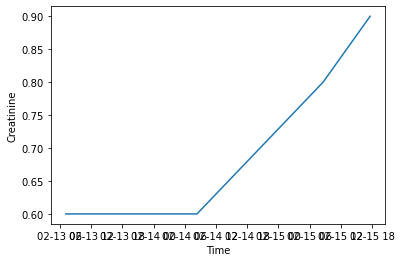

In [29]:
plotCreatinineTrajectory('MR2110315', rows = slice(0,4))asdf

In [30]:
#captured_patients['RMW'].intersection(captured_patients['HBT']) # HBT & RMW
#captured_patients['HBT'].intersection(captured_patients['HBT']).intersection(captured_patients['BCI'])

In [ ]:
examplePatient = None # Replace with sample patient 
e1_creatTS = df.loc[df.patient_id == examplePatient, ['time', 'creatinine', 'RMW']]
plt.plot(e1_creatTS.time, e1_creatTS.creatinine)
plt.xlabel("time")
plt.ylabel("creatinine")
for t_aki in e1_creatTS[e1_creatTS.RMW].time:
    plt.arrow(x = t_aki, y = 0.3, dx=0, dy=0.5, width=0.08, color = '#FFEBC1')
    
# Parameters 
creatTS = df.loc[df.patient_id == examplePatient, ['time', 'creatinine', 'RMW']] # this is the raw time series of the patient
draws = 10 # How many times to draw the line
diff_linewidth = 1.05 # Different line widths each draw
alpha_value = 0.03 # Alpha values of glow effect
glow_size = 5 # Glow linewidth
mainDrawColor = "#eae8ff"
bgColor = "#361F27"
# Nice colors (main trajectory): 
# green - "#00a676"
# pink - fe938c
# yellowgreen - E2F89C
# Laurel green - bdc4a7
# lavendar - eae8ff

# FIGURE 1: Create a figure for the creatinine trajectory
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(creatTS.time, creatTS.creatinine, color = mainDrawColor) 
plt.xlabel("time")
plt.ylabel("creatinine")


arrowBounds = [sum(_) for _ in zip(list(e1_creatTS[e1_creatTS.RMW].creatinine)*3, [-0.3, 0, 0.3])]

axProps = dict()
axProps['text'] = "AKI event"
axProps['xy'] = (t_aki, arrowBounds[1])
axProps['xytext'] = (t_aki, arrowBounds[2])
axProps['arrowprops'] = {'arrowstyle': '-|>'}
axProps['va'] = 'center'
for t_aki in e1_creatTS[e1_creatTS.RMW].time:
    axProps = dict()
    axProps['text'] = "AKI event"
    axProps['xy'] = (t_aki, arrowBounds[1])
    axProps['xytext'] = (t_aki, arrowBounds[2])
    axProps['arrowprops'] = {'arrowstyle': '-|>'}
    axProps['va'] = 'center'
    ax.annotate(**axProps)
ax.set_facecolor(bgColor)
# Neon effect:
draws = 10 # How many times to draw the line
diff_linewidth = 1.05 # Different line widths each draw
alpha_value = 0.03 # Alpha values of glow effect
glow_size = 5 # Glow linewidth

for n in range(draws):
    ax.plot(creatTS.time, creatTS.creatinine, color = mainDrawColor,
            linewidth=glow_size+(diff_linewidth*n), alpha = alpha_value)
# Nice colors (background):
# dark grey - #5d576b
# beige - #EFD09E
# burgundy - #361F27

In [ ]:
# Define time to AKI event (from admission)

# df[~df['death_time'].isnull()]
df['aki.{}_time'.format(flaggerDefinitions[0])] = df[df.RMW > 0].time
df['time2aki'] = df['aki.RMW_time'] - pd.to_datetime(df.admission)
# plt.hist(df['time2aki'].astype('timedelta64[h]'))
# sns.distplot(df.time2aki.astype('timedelta64[h]'))
plt.hist(df['time2aki'].astype('timedelta64[h]'))

In [ ]:
#plt.hist(df['time2aki'].astype('timedelta64[h]'))
#sns.distplot(df.time2aki.astype('timedelta64[h]'))
plt.hist(df['time2aki'].astype('timedelta64[h]'))

---

*changing up a bit here; work in progress...*

---


In [ ]:
dataFolder
#pd.read_csv(os.path.join(dataFolder, "flaggerInput.csv"))

In [ ]:
captured_patients = dict()
captured_patientsLIST = [set(pDF1[pDF1[col] > STAGE - 1].index.get_level_values(level='patient_id').unique()) for col in flaggerDefinitions]
captured_patients[flaggerDefinitions[0]], captured_patients[flaggerDefinitions[1]], captured_patients[flaggerDefinitions[2]] = captured_patientsLIST 

In [ ]:
for DFN, SET in captured_patients.items():
    print(DFN, len(SET))
    print("{DFN}")

    print(len(SET) / pDF1.index.get_level_values(level="patient_id").nunique())

In [ ]:
pDF1.index.get_level_values(level="patient_id").nunique()

In [ ]:
# Read in data
pDF1 = pd.read_csv(dataPath)
pDF1['time'] = pd.to_datetime(pDF1.time)
print(pDF1.shape)

qDF2 = pd.read_csv(outcomesPath)
qDF2['time'] = pd.to_datetime(qDF2.time)
print(qDF2.shape)

assert np.all(pDF1[['patient_id', 'time']] == qDF2[['patient_id', 'time']]) # CHECK
# Combine dataframe with definitions with dataframe with (hard) outcomes
combined = pDF1.merge(qDF2)

# Add in admission column
combined = f.returnAKIpatients(combined)
combined['admission'] = combined['imputed_admission']
combined = combined.drop(['imputed_admission', 'aki'], axis = 1)
combined = combined.reset_index()

In [ ]:
# Write out the dataFRAME with the admission column
outPath =  os.path.join(dataFolder, "flaggerAdmission.csv")
combined.to_csv(outPath, index = False)

# Right after writing out, Yu mentioned the problem that one patient has multiple
# admissions in a dataset which theoretically only contains the first encounters...
# Something strange is happening

In [ ]:
 # Create outcome3: Creatinine >= 2x creatinine at admission
combined['admissionCreatinine'] = combined.loc[combined.time == combined.admission].creatinine
combined['admissionCreatinine'] = combined.admissionCreatinine.ffill() # Find admit creat

combined['outcome3'] = combined.creatinine >= 2*combined.admissionCreatinine
combined.head()

In [ ]:
#"H:\AKIFlagger\output\flagger creatinine data 03-28-2022.csv"

In [ ]:
comb_olpp = combined[['patient_id', 'RMW', 'HBT', 'BCI']].groupby('patient_id').any()
comb_olpp['outcome3'] = combined.groupby('patient_id').outcome3.any()

In [ ]:
comb_olpp.head()

In [ ]:
cmRMW = printDescriptiveStatistics(yTRUE = "outcome3", yPRED = flaggerDefinitions[0], dataFRAME = comb_olpp)
cmHBT = printDescriptiveStatistics(yTRUE = "outcome3", yPRED = flaggerDefinitions[1], dataFRAME = comb_olpp)
cmBCI = printDescriptiveStatistics(yTRUE = "outcome3", yPRED = flaggerDefinitions[2], dataFRAME = comb_olpp)

## Check 
print(7698 + 2762 == comb_olpp[comb_olpp[flaggerDefinitions[0]] > 0].index.nunique())
print(9389 + 3083 == comb_olpp[comb_olpp[flaggerDefinitions[1]] > 0].index.nunique())
print(9389 + 3083 == comb_olpp[comb_olpp[flaggerDefinitions[2]] > 0].index.nunique())
print([comb_olpp[comb_olpp[flaggerDefinitions[d]] > 0].index.nunique() for d in range(3)])